## Set up and import 

In [275]:
import io
import os
import sys
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, GPTNeoXForCausalLM # AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM, 

device = "cuda:0" 

In [276]:
import umap

In [277]:
df = pd.read_csv(f'{os.path.dirname(os.getcwd())}/data/jigsaw_toxic/train.csv') 
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Config

In [278]:
n = 1000
toxic = [df[df['toxic']==1]['comment_text'][i:i+1].to_string(index=False) for i in range(0,n)]
non_toxic = [df[df['toxic']==0]['comment_text'][i:i+1].to_string(index=False) for i in range(0,n)]

In [279]:
model_name = "eleuther-pythia2.8b-hh-sft"
layer = -5
cache_dir = None

## Load hidden states for base, sft and dpo

pythia-2.8b: Residual stream dimension 2560

In [261]:
x = []
y = []
for idx, model_name in enumerate(["pythia-2.8b","eleuther-pythia2.8b-hh-sft","eleuther-pythia2.8b-hh-dpo"]):
  model_SAVEFOLD0 = f"{os.path.dirname(os.getcwd())}/outputs/{model_name}"
  model_SAVEFOLD = f"{model_SAVEFOLD0}/layer{layer}/"

  toxic_f = f"{model_SAVEFOLD}toxic_hs.npy"
  non_toxic_f = f"{model_SAVEFOLD}non_toxic_hs.npy"
  toxic_hs = np.load(toxic_f, mmap_mode = 'r')
  non_toxic_hs = np.load(non_toxic_f, mmap_mode = 'r')

  x.append(np.concatenate([non_toxic_hs, toxic_hs],0))
  y.append(np.concatenate([np.array(len(non_toxic)*[2*idx]), np.array(len(toxic)*[2*idx+1])],0))

x = np.concatenate([x[0], x[1], x[2]],0) 
y = np.concatenate([y[0], y[1], y[2]],0) 

Differences between models for same prompt

In [272]:
base_sft_dot = np.empty([int(len(x)/3)])
base_sft_sim = np.empty([int(len(x)/3)])
base_sft_diff = np.empty([int(len(x)/3)])
base_dpo_dot = np.empty([int(len(x)/3)])
base_dpo_sim = np.empty([int(len(x)/3)])
base_dpo_diff = np.empty([int(len(x)/3)])
sft_dpo_dot = np.empty([int(len(x)/3)])
sft_dpo_sim = np.empty([int(len(x)/3)])
sft_dpo_diff = np.empty([int(len(x)/3)])
for i in range(int(len(x)/3)):
    base_sft_dot[i] = np.dot(x[i], x[i+2*n])
    base_sft_sim[i] = base_sft_dot[i]/(np.linalg.norm(x[i])*np.linalg.norm(x[i+2*n]))
    base_sft_diff[i] = np.mean(abs(x[i] - x[i+2*n]))
    # print(i, i+2*n)

for i in range(int(len(x)/3)):
    sft_dpo_dot[i] = np.dot(x[i+2*n], x[i+4*n])
    sft_dpo_sim[i] = sft_dpo_dot[i]/(np.linalg.norm(x[i+2*n])*np.linalg.norm(x[i+4*n]))
    sft_dpo_diff = np.mean(abs(x[i+2*n] - x[i+4*n]))
    # print(i+2*n, i+4*n)

for i in range(int(len(x)/3)):
    base_dpo_dot[i] = np.dot(x[i], x[i+4*n])
    base_dpo_sim[i] = base_dpo_dot[i]/(np.linalg.norm(x[i])*np.linalg.norm(x[i+4*n]))
    base_dpo_diff[i] = np.mean(abs(x[i] - x[i+4*n]))
    # print(i, i+4*n)

In [273]:
print(np.mean(base_sft_sim))
print(np.mean(base_dpo_sim))
print(np.mean(sft_dpo_sim))

0.9998357861391008
0.9996707941304714
0.9998122601762877


In [274]:
print(np.mean(base_sft_diff))
print(np.mean(base_dpo_diff))
print(np.mean(sft_dpo_diff))

0.19672042409330606
0.2699879312068224
0.21844046


Look at all layers

In [325]:
layers = [f.name for f in os.scandir(model_SAVEFOLD0) if f.is_dir()][2:]

mean_base_sft_diffs=[]
mean_base_dpo_diffs=[]
mean_sft_dpo_diffs=[]


for layer in layers: 

    x = []
    y = []
    for idx, model_name in enumerate(["pythia-2.8b","eleuther-pythia2.8b-hh-sft","eleuther-pythia2.8b-hh-dpo"]):
      model_SAVEFOLD0 = f"{os.path.dirname(os.getcwd())}/outputs/{model_name}"
      model_SAVEFOLD = f"{model_SAVEFOLD0}/{layer}/"
    
      toxic_f = f"{model_SAVEFOLD}toxic_hs.npy"
      non_toxic_f = f"{model_SAVEFOLD}non_toxic_hs.npy"
      toxic_hs = np.load(toxic_f, mmap_mode = 'r')
      non_toxic_hs = np.load(non_toxic_f, mmap_mode = 'r')
    
      x.append(np.concatenate([non_toxic_hs, toxic_hs],0))
      y.append(np.concatenate([np.array(len(non_toxic)*[2*idx]), np.array(len(toxic)*[2*idx+1])],0))
    
    x = np.concatenate([x[0], x[1], x[2]],0) 
    y = np.concatenate([y[0], y[1], y[2]],0) 
    
    base_sft_dot = np.empty([int(len(x)/3)])
    base_sft_sim = np.empty([int(len(x)/3)])
    base_sft_diff = np.empty([int(len(x)/3)])
    base_dpo_dot = np.empty([int(len(x)/3)])
    base_dpo_sim = np.empty([int(len(x)/3)])
    base_dpo_diff = np.empty([int(len(x)/3)])
    sft_dpo_dot = np.empty([int(len(x)/3)])
    sft_dpo_sim = np.empty([int(len(x)/3)])
    sft_dpo_diff = np.empty([int(len(x)/3)])
    for i in range(int(len(x)/3)):
        base_sft_dot[i] = np.dot(x[i], x[i+2*n])
        base_sft_sim[i] = base_sft_dot[i]/(np.linalg.norm(x[i])*np.linalg.norm(x[i+2*n]))
        base_sft_diff[i] = np.mean(abs(x[i] - x[i+2*n]))
        # print(i, i+2*n)
    
    for i in range(int(len(x)/3)):
        sft_dpo_dot[i] = np.dot(x[i+2*n], x[i+4*n])
        sft_dpo_sim[i] = sft_dpo_dot[i]/(np.linalg.norm(x[i+2*n])*np.linalg.norm(x[i+4*n]))
        sft_dpo_diff = np.mean(abs(x[i+2*n] - x[i+4*n]))
        # print(i+2*n, i+4*n)
    
    for i in range(int(len(x)/3)):
        base_dpo_dot[i] = np.dot(x[i], x[i+4*n])
        base_dpo_sim[i] = base_dpo_dot[i]/(np.linalg.norm(x[i])*np.linalg.norm(x[i+4*n]))
        base_dpo_diff[i] = np.mean(abs(x[i] - x[i+4*n]))
        # print(i, i+4*n)
    
    print(f"{layer}, base_sft_diff: {np.mean(base_sft_diff)}, base_dpo_diff: {np.mean(base_dpo_diff)}, sft_dpo_diff: {np.mean(sft_dpo_diff)}")
    
    mean_base_sft_diffs.append(np.mean(base_sft_diff))
    mean_base_dpo_diffs.append(np.mean(base_dpo_diff))
    mean_sft_dpo_diffs.append(np.mean(sft_dpo_diff))                                                                                                                   

layer0, base_sft_diff: 0.0, base_dpo_diff: 0.0, sft_dpo_diff: 0.0
layer1, base_sft_diff: 0.021696555278263988, base_dpo_diff: 0.039384984713047744, sft_dpo_diff: 0.029736798256635666
layer2, base_sft_diff: 0.034296440213918686, base_dpo_diff: 0.060443094309419396, sft_dpo_diff: 0.046669382601976395
layer3, base_sft_diff: 0.045213363986462356, base_dpo_diff: 0.07723615378141403, sft_dpo_diff: 0.0594133660197258
layer4, base_sft_diff: 0.052015463408082725, base_dpo_diff: 0.08926963015273214, sft_dpo_diff: 0.06973303854465485
layer5, base_sft_diff: 0.06070956869795918, base_dpo_diff: 0.100540738157928, sft_dpo_diff: 0.07644128799438477
layer6, base_sft_diff: 0.06917332918941975, base_dpo_diff: 0.11231085776165128, sft_dpo_diff: 0.08557814359664917
layer7, base_sft_diff: 0.07465585188195109, base_dpo_diff: 0.12030826709419488, sft_dpo_diff: 0.09178666770458221
layer8, base_sft_diff: 0.07909995602071285, base_dpo_diff: 0.12655081157386303, sft_dpo_diff: 0.09735612571239471
layer9, base_sft_

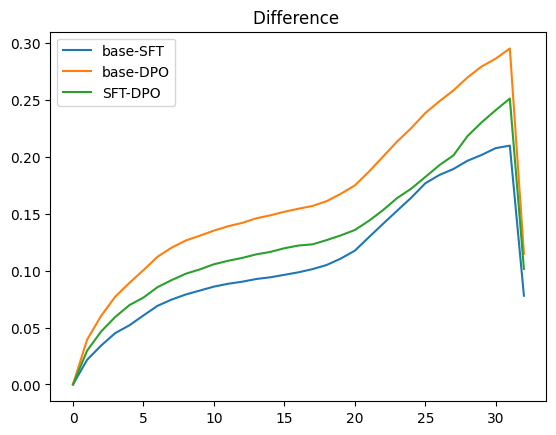

In [326]:
plt.plot(mean_base_sft_diffs)
plt.plot(mean_base_dpo_diffs)
plt.plot(mean_sft_dpo_diffs)
plt.title("Difference ")
plt.legend(["base-SFT", "base-DPO", "SFT-DPO"])

Plot with UMA

In [53]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink','green', 'purple', 'yellow'])


In [54]:
XY_UMAP = umap.UMAP(n_components=2).fit_transform(x)


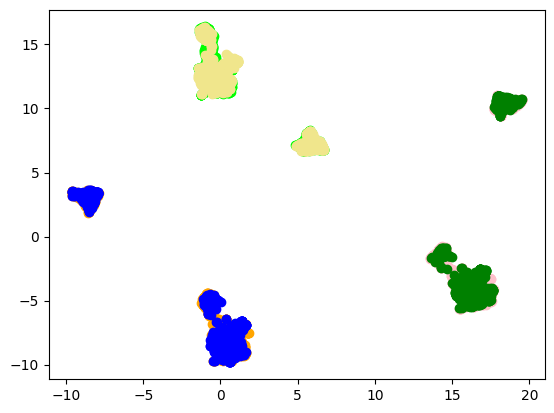

In [55]:
for i in range(6):
  plt.scatter(XY_UMAP[i*n:i*n+n,0],
                        XY_UMAP[i*n:i*n+n,1],
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

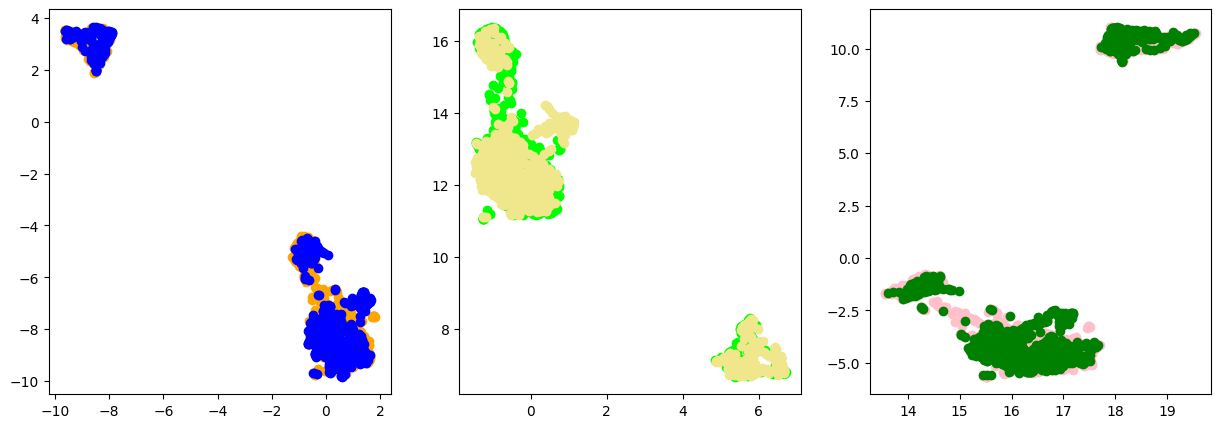

In [56]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
for i in range(2):
  ax1.scatter(XY_UMAP[i*n:i*n+n,0],
                        XY_UMAP[i*n:i*n+n,1],
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

for i in range(2):
  ax2.scatter(XY_UMAP[2*n + i*n:2*n + i*n+n,0],
                        XY_UMAP[2*n + i*n:2*n + i*n+n,1],
                        c=colors[2+i%colors.size],
                        label = 'cluster '+str(2+i))

for i in range(2):
  ax3.scatter(XY_UMAP[4*n + i*n:4*n + i*n+n,0],
                        XY_UMAP[4*n + i*n:4*n + i*n+n,1],
                        c=colors[4+i%colors.size],
                        label = 'cluster '+str(4+i))
  

In [73]:
print(np.dot(x[0], x[1000]))
print(np.linalg.norm(x[0])*np.linalg.norm(x[1000]))
print( np.dot(x[0], x[1000]) / (np.linalg.norm(x[0])*np.linalg.norm(x[1000])) )

9754.154
9759.605
0.99944144


In [70]:
print(np.dot(x[0], x[2000]))
print(np.linalg.norm(x[0])*np.linalg.norm(x[2000]))
print( np.dot(x[i], x[2000]) / (np.linalg.norm(x[0])*np.linalg.norm(x[2000])) )

9704.164
9717.632
0.9953778


In [72]:
print( np.argmax(x[0]) )
print(x[0][530])
print(x[1000][530])
print(x[2000][530])

530
38.82148
38.625706
39.08879


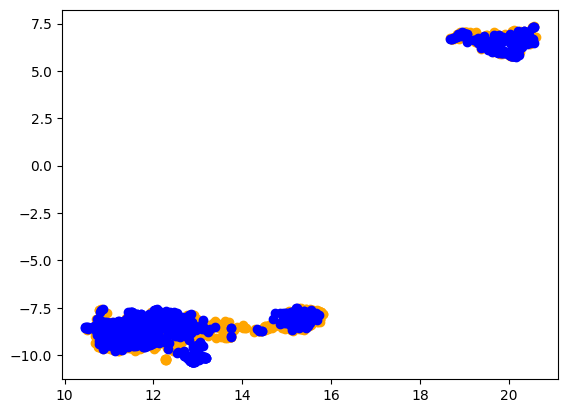

In [107]:
for i in range(2):
    plt.scatter(XY_UMAP[i*n:i*n+n,0],
                        XY_UMAP[i*n:i*n+n,1],
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

In [129]:
km = KMeans(n_clusters=2, init='random',n_init=10, max_iter=300,) # tol=1e-04, random_state=0

In [132]:
umap_cluster = km.fit_predict(XY_UMAP[0*n:2*n,:])

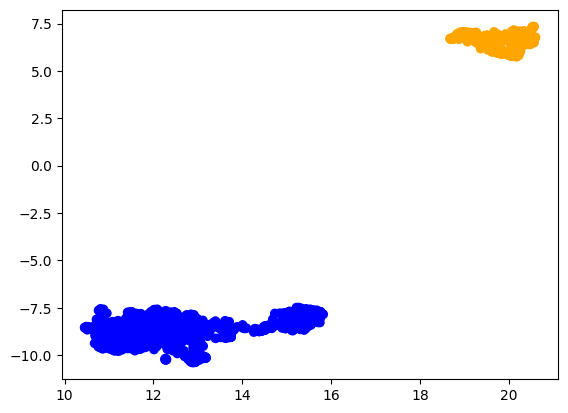

In [134]:
plt.scatter(XY_UMAP[0:2*n,0],
            XY_UMAP[0:2*n,1],
            c=colors[umap_cluster%colors.size],
            label = 'cluster '+str(umap_cluster))

In [139]:
x_cluster = km.fit_predict(x[0*n:2*n,:])

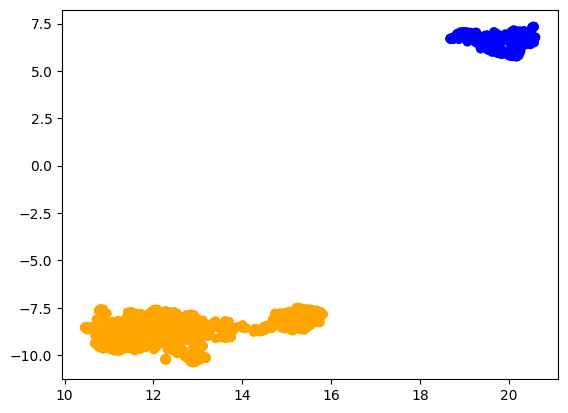

In [140]:
plt.scatter(XY_UMAP[0:2*n,0],
            XY_UMAP[0:2*n,1],
            c=colors[x_cluster%colors.size],
            label = 'cluster '+str(x_cluster))

In [144]:
non_toxic[0][-5:]

'na...'

In [141]:
for i in range(20):
    print(x_cluster[i], non_toxic[i])

0 Explanation\nWhy the edits made under my userna...
0 D'aww! He matches this background colour I'm se...
1 Hey man, I'm really not trying to edit war. It'...
0 "\nMore\nI can't make any real suggestions on i...
1 You, sir, are my hero. Any chance you remember ...
0 "\n\nCongratulations from me as well, use the t...
0 Your vandalism to the Matt Shirvington article ...
0 Sorry if the word 'nonsense' was offensive to y...
0 alignment on this subject and which are contrar...
1 "\nFair use rationale for Image:Wonju.jpg\n\nTh...
0 bbq \n\nbe a man and lets discuss it-maybe over...
0 Before you start throwing accusations and warni...
0 Oh, and the girl above started her arguments wi...
0 "\n\nJuelz Santanas Age\n\nIn 2002, Juelz Santa...
0 REDIRECT Talk:Voydan Pop Georgiev- Chernodrinski
0 The Mitsurugi point made no sense - why not arg...
0 Don't mean to bother you \n\nI see that you're ...
0 "\n\n Regarding your recent edits \n\nOnce agai...
1 "\nGood to know. About me, yeah, I'm studying 

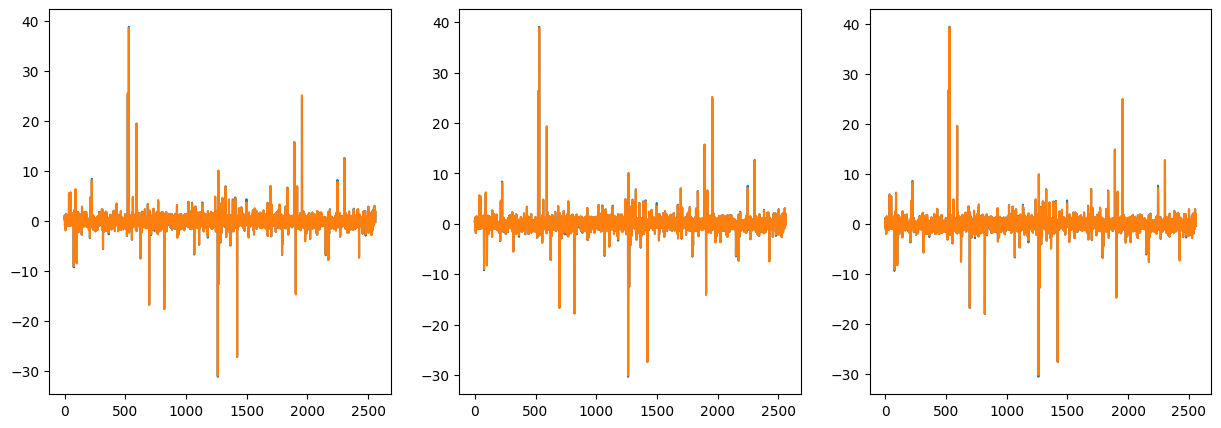

In [104]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(x[0])
ax[0].plot(x[1000])
ax[1].plot(x[2000])
ax[1].plot(x[3000])
ax[2].plot(x[4000])
ax[2].plot(x[5000])

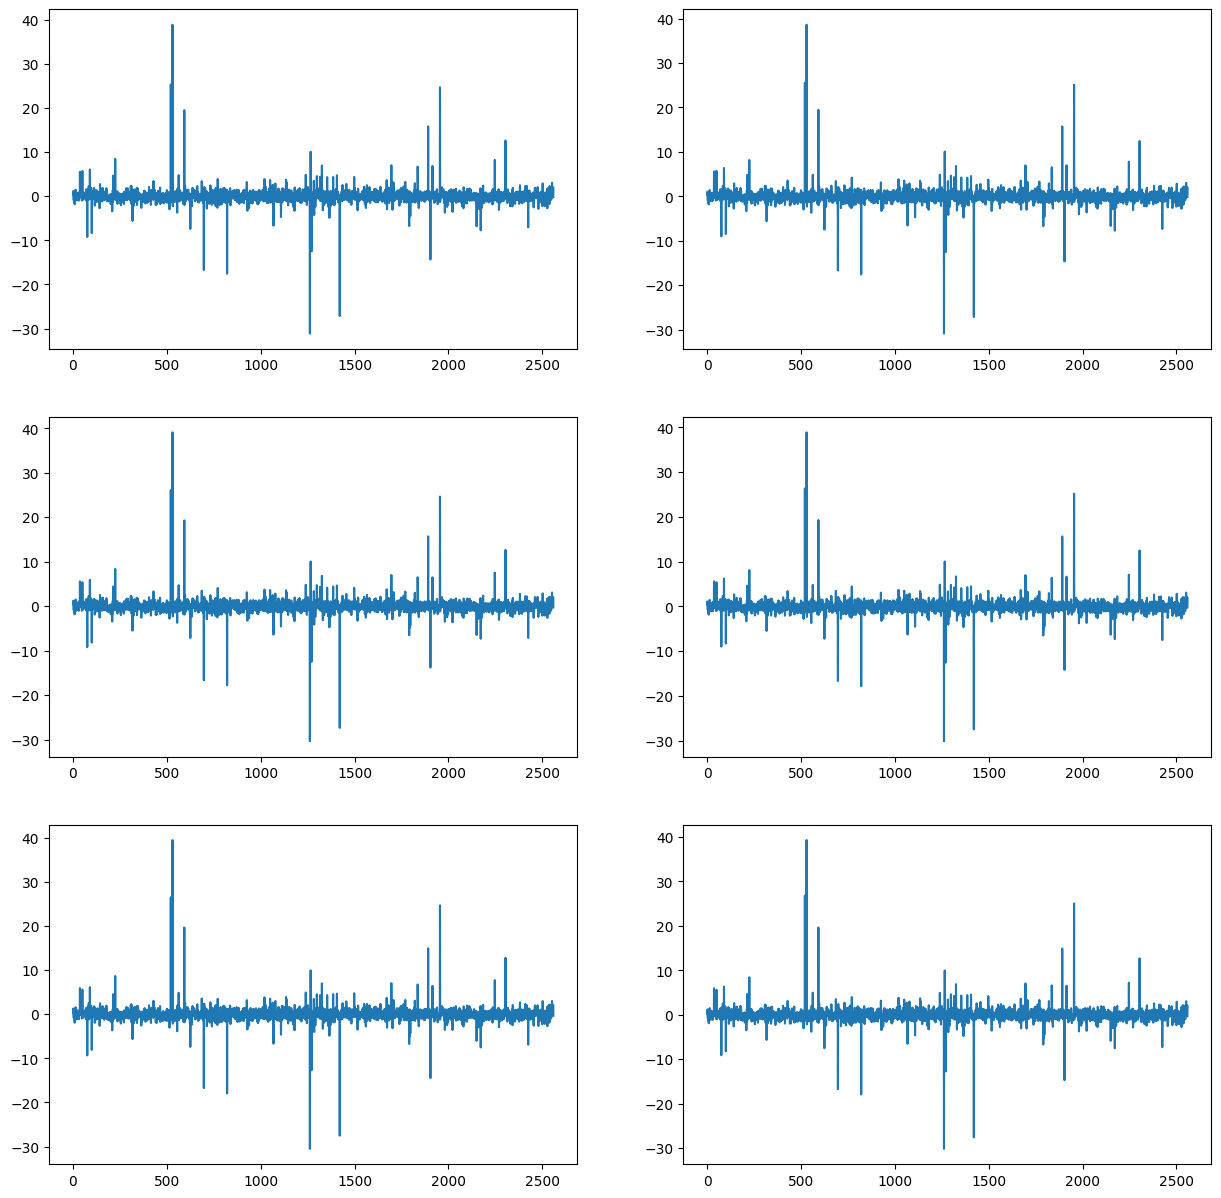

In [102]:
f, ax = plt.subplots(3, 2, figsize=(15, 15))
ax[0,0].plot(x[0])
ax[0,1].plot(x[1000])
ax[1,0].plot(x[2000])
ax[1,1].plot(x[3000])
ax[2,0].plot(x[4000])
ax[2,1].plot(x[5000])

## Logistic regression

In [262]:
# let's create a simple 50/50 train split
base_non_toxic_hs_train, base_non_toxic_hs_test = x[:n//2], x[n//2:n]
base_toxic_hs_train, base_toxic_hs_test = x[n:n+n//2], x[n+n//2:2*n]

x_base_train = np.concatenate([base_non_toxic_hs_train, base_toxic_hs_train],0)
x_base_test = np.concatenate([base_non_toxic_hs_test, base_toxic_hs_test],0)
y_base_train = np.concatenate([np.array(len(base_non_toxic_hs_train)*[0]), np.array(len(base_toxic_hs_train)*[1])],0)
y_base_test = np.concatenate([np.array(len(base_non_toxic_hs_test)*[0]), np.array(len(base_toxic_hs_test)*[1])],0)

In [263]:
lr = LogisticRegression(class_weight="balanced", max_iter=1000)

In [264]:
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [265]:
print("Logistic regression accuracy: {}".format(lr.score(x_test, y_test)))

Logistic regression accuracy: 0.828


sft

In [266]:
# let's create a simple 50/50 train split
sft_non_toxic_hs_train, sft_non_toxic_hs_test = x[2*n:2*n+n//2], x[2*n+n//2:3*n]
sft_toxic_hs_train, sft_toxic_hs_test = x[3*n:3*n+n//2], x[3*n+n//2:4*n]

x_sft_train = np.concatenate([sft_non_toxic_hs_train, sft_toxic_hs_train],0)
x_sft_test = np.concatenate([sft_non_toxic_hs_test, sft_toxic_hs_test],0)
y_sft_train = np.concatenate([np.array(len(sft_non_toxic_hs_train)*[0]), np.array(len(sft_toxic_hs_train)*[1])],0)
y_sft_test = np.concatenate([np.array(len(sft_non_toxic_hs_test)*[0]), np.array(len(sft_toxic_hs_test)*[1])],0)

In [267]:
lr.fit(x_dpo_train, y_sft_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [268]:
print("Logistic regression accuracy: {}".format(lr.score(x_sft_test, y_sft_test)))

Logistic regression accuracy: 0.83


dpo

In [269]:
# let's create a simple 50/50 train split
dpo_non_toxic_hs_train, dpo_non_toxic_hs_test = x[4*n:4*n+n//2], x[4*n+n//2:5*n]
dpo_toxic_hs_train, dpo_toxic_hs_test = x[5*n:5*n+n//2], x[5*n+n//2:6*n]

x_dpo_train = np.concatenate([dpo_non_toxic_hs_train, dpo_toxic_hs_train],0)
x_dpo_test = np.concatenate([dpo_non_toxic_hs_test, dpo_toxic_hs_test],0)
y_dpo_train = np.concatenate([np.array(len(dpo_non_toxic_hs_train)*[0]), np.array(len(dpo_toxic_hs_train)*[1])],0)
y_dpo_test = np.concatenate([np.array(len(dpo_non_toxic_hs_test)*[0]), np.array(len(dpo_toxic_hs_test)*[1])],0)

In [270]:
lr.fit(x_dpo_train, y_dpo_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [271]:
print("Logistic regression accuracy: {}".format(lr.score(x_dpo_test, y_dpo_test)))

Logistic regression accuracy: 0.827


|-1|-2|-3|-4|-5|
|---|---|---|---|---|
|0.834|0.831|0.828|0.831|0.828|
|0.836|0.833|0.829|0.832|0.83|
|0.838|0.83|0.825|0.824|0.827|

## Transformer lens

Forked TransformerLens and added functionality for HF lomahony pythia models. 

git clone https://github.com/lomahony/TransformerLens

cd TransformerLens

pip3 install -e .

In [6]:
!pip list

Package                   Version              Editable project location
------------------------- -------------------- ---------------------------
absl-py                   1.4.0
accelerate                0.21.0
aiohttp                   3.8.4
aiosignal                 1.3.1
anthropic                 0.3.11
antlr4-python3-runtime    4.9.3
anyio                     3.7.1
apex                      0.1
appdirs                   1.4.4
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
arrow                     1.2.3
asttokens                 2.2.1
async-lru                 2.0.4
async-timeout             4.0.2
attrs                     23.1.0
Babel                     2.12.1
backcall                  0.2.0
beartype                  0.14.1
beautifulsoup4            4.12.2
best-download             0.0.9
bleach                    6.0.0
blessed                   1.20.0
cachetools                5.3.1
certifi                   2019.11.28
cffi                      1.15.1
chardet

In [7]:
sys.path.append(f'{os.path.dirname( os.path.dirname(os.getcwd()))}/TransformerLens')

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from fancy_einsum import einsum
from torchtyping import TensorType as TT
from typing import List, Optional, Callable, Tuple, Union
import functools
from tqdm import tqdm
from IPython.display import display

from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import transformer_lens 
torch.set_grad_enabled(False)

In [9]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")

tl_model_base = transformer_lens.HookedTransformer.from_pretrained("pythia-70m")
tl_model_sft = transformer_lens.HookedTransformer.from_pretrained("lomahony/eleuther-pythia70m-hh-sft")
tl_model_dpo = transformer_lens.HookedTransformer.from_pretrained("lomahony/eleuther-pythia70m-hh-dpo")


Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model lomahony/eleuther-pythia70m-hh-sft into HookedTransformer


Using pad_token, but it is not set yet.


Loaded pretrained model lomahony/eleuther-pythia70m-hh-dpo into HookedTransformer


In [ ]:
# hf_model_sft = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia70m-hh-sft").to("cpu")
# tl_model_sft = HookedTransformer.from_pretrained("lomahony/eleuther-pythia70m-hh-sft",
#     hf_model=hf_model_sft,
#     device="cpu",
#     tokenizer=tokenizer,
# ).to("cuda" if torch.cuda.is_available() else "cpu")

# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf", device_map="auto")
#     model = HookedTransformer.from_pretrained(
#     name,
#     hf_model=hf_model,
#     fold_value_biases=False,
#     fold_ln=False,
#     tokenizer=tokenizer,
#     n_device=2,
#     move_to_device=False,
#     center_writing_weights=False,
# )

## Model weights

In [11]:


tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m", cache_dir=cache_dir)
model_base = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-70m", cache_dir=cache_dir)
model_base.cuda()

# tokenizer = AutoTokenizer.from_pretrained("lomahony/eleuther-pythia70m-hh-sft", cache_dir=cache_dir)
model_sft = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia70m-hh-sft", cache_dir=cache_dir)
model_sft.cuda()

# tokenizer = AutoTokenizer.from_pretrained("lomahony/eleuther-pythia70m-hh-dpo", cache_dir=cache_dir)
model_dpo = GPTNeoXForCausalLM.from_pretrained("lomahony/eleuther-pythia70m-hh-dpo", cache_dir=cache_dir)
model_dpo.cuda()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attention): GPTNeoXAttention(
          (rotary_emb): RotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (embed_out): Linear(in_features=512, out_features=50304, bias=False)
)

### Look at how much the layers and parameters change on average

In [12]:
i=0
for name, param in model_base.named_parameters():
    if param.requires_grad:
        print(type(param), name, param.size())
        i+=1
print(i)

<class 'torch.nn.parameter.Parameter'> gpt_neox.embed_in.weight torch.Size([50304, 512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.input_layernorm.weight torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.input_layernorm.bias torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.post_attention_layernorm.weight torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.post_attention_layernorm.bias torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.attention.query_key_value.weight torch.Size([1536, 512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.attention.query_key_value.bias torch.Size([1536])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.attention.dense.weight torch.Size([512, 512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.attention.dense.bias torch.Size([512])
<class 'torch.nn.parameter.Parameter'> gpt_neox.layers.0.mlp.dense_h_to_4h.weight tor

In [13]:
list(model_base.parameters())[-2]

Parameter containing:
tensor([ 4.1016e+00, -6.9336e+00, -3.9141e+00, -8.5469e+00, -6.9531e+00,
        -7.1172e+00, -5.4570e+00,  5.5391e+00,  5.3555e+00, -6.5820e+00,
        -9.1016e+00, -5.2461e+00, -6.0391e+00,  3.9023e+00,  1.0039e+01,
         6.9102e+00, -1.0398e+01, -6.2578e+00,  6.0781e+00, -4.8125e+00,
         1.0000e+01,  7.2422e+00,  9.5801e-01,  6.6680e+00,  8.0391e+00,
         4.3633e+00, -9.3359e+00,  8.2969e+00,  6.7578e+00, -5.9766e+00,
        -6.7852e+00,  6.2451e-01,  9.0312e+00,  3.7441e+00, -6.1992e+00,
        -7.8789e+00, -4.5469e+00, -1.3877e+00,  8.9375e+00, -5.4258e+00,
        -6.3867e+00,  6.9219e+00, -7.9492e+00,  7.8242e+00, -2.3750e+00,
        -7.8281e+00,  8.5781e+00,  5.7188e+00,  8.0625e+00, -1.1867e+01,
        -3.2812e+00,  5.6914e+00, -9.3594e+00, -4.9219e+00,  6.0820e+00,
         5.9141e+00,  6.6953e+00, -1.0953e+01,  1.9600e+00,  5.3516e+00,
        -3.8398e+00, -8.5938e+00, -1.0703e+01, -7.8867e+00, -4.7695e+00,
         1.0516e+01,  7.0000e

In [14]:
base_sft_diff=[]
base_dpo_diff=[]
sft_dpo_diff=[]
#  len(list(model_dpo.parameters())) # 76

for i in range( len( list( model_base.parameters() ) ) ):
    mean = np.mean( (list(model_base.parameters())[i] - list(model_sft.parameters())[i]).detach().cpu().numpy() )
    base_sft_diff.append( mean )

for i in range( len( list( model_base.parameters() ) ) ):
    mean = np.mean( (list(model_base.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() )
    base_dpo_diff.append( mean )
    
for i in range( len( list( model_sft.parameters() ) ) ):
    mean = np.mean( (list(model_sft.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() )
    sft_dpo_diff.append( mean )

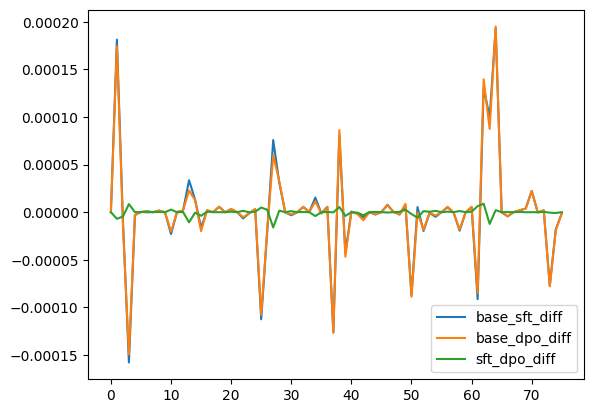

In [15]:
plt.plot(base_sft_diff)
plt.plot(base_dpo_diff)
plt.plot(sft_dpo_diff)
plt.title("Difference ")
plt.legend(["base-SFT", "base-DPO", "SFT-DPO"])

In [16]:
base_sft_diff_abs = [abs(item) for item in base_sft_diff]
base_sft_diff_abs_max = list(np.argsort(base_sft_diff_abs)[::-1][:10])
print(base_sft_diff_abs_max)
names = [name for name, param in list(model_base.named_parameters())]
print([base_sft_diff_abs[i] for i in base_sft_diff_abs_max])
[names[i] for i in base_sft_diff_abs_max]

[64, 1, 3, 62, 37, 25, 63, 61, 50, 38]
[0.00019297613, 0.00018124306, 0.00015794032, 0.00013075772, 0.00012637943, 0.00011255813, 9.9787256e-05, 9.142619e-05, 8.695412e-05, 8.076195e-05]


['gpt_neox.layers.5.post_attention_layernorm.bias',
 'gpt_neox.layers.0.input_layernorm.weight',
 'gpt_neox.layers.0.post_attention_layernorm.weight',
 'gpt_neox.layers.5.input_layernorm.bias',
 'gpt_neox.layers.3.input_layernorm.weight',
 'gpt_neox.layers.2.input_layernorm.weight',
 'gpt_neox.layers.5.post_attention_layernorm.weight',
 'gpt_neox.layers.5.input_layernorm.weight',
 'gpt_neox.layers.4.input_layernorm.bias',
 'gpt_neox.layers.3.input_layernorm.bias']

### What proportion of model weights haven't changed?

In [17]:
base_sft_nonzero=[]
base_dpo_nonzero=[]
sft_dpo_nonzero=[]
#  len(list(model_dpo.parameters())) # 76

for i in range( len( list( model_base.parameters() ) ) ):
    non_zero = ((list(model_base.parameters())[i] - list(model_sft.parameters())[i]).detach().cpu().numpy() != 0).sum()
    size = 1
    for dim in np.shape( ((list(model_base.parameters())[i] - list(model_sft.parameters())[i]).detach().cpu().numpy() != 0) ): 
        size *= dim
    base_sft_nonzero.append( non_zero/size )

for i in range( len( list( model_base.parameters() ) ) ):
    non_zero = ((list(model_base.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() != 0).sum()
    size = 1
    for dim in np.shape( ((list(model_base.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() != 0) ): 
        size *= dim
    base_dpo_nonzero.append( non_zero/size )

for i in range( len( list( model_sft.parameters() ) ) ):
    non_zero = ((list(model_sft.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() != 0).sum()
    size = 1
    for dim in np.shape( ((list(model_sft.parameters())[i] - list(model_dpo.parameters())[i]).detach().cpu().numpy() != 0) ): 
        size *= dim
    sft_dpo_nonzero.append( non_zero/size )

In [18]:
base_sft_nonzero_sorted = np.argsort(base_sft_nonzero)
[base_sft_nonzero[i] for i in base_sft_nonzero_sorted][:10]
names = [name for name, param in list(model_base.named_parameters())]
print("Layers least affected by fine tuning: ")
print([names[i] for i in base_sft_nonzero_sorted[:10]])
print("How much these layers are affected by fine tuning: ")
print([base_sft_nonzero[i] for i in base_sft_nonzero_sorted[:10]])

Layers least affected by fine tuning: 
['gpt_neox.embed_in.weight', 'gpt_neox.layers.3.attention.query_key_value.bias', 'gpt_neox.layers.5.attention.query_key_value.bias', 'gpt_neox.layers.4.attention.query_key_value.bias', 'gpt_neox.layers.4.input_layernorm.weight', 'gpt_neox.final_layer_norm.bias', 'gpt_neox.final_layer_norm.weight', 'gpt_neox.layers.2.attention.query_key_value.bias', 'gpt_neox.layers.2.post_attention_layernorm.weight', 'gpt_neox.layers.3.input_layernorm.weight']
How much these layers are affected by fine tuning: 
[0.841842146623529, 0.9876302083333334, 0.98828125, 0.9889322916666666, 0.99609375, 0.99609375, 0.998046875, 0.998046875, 0.998046875, 0.998046875]


In [19]:
base_dpo_nonzero_sorted = np.argsort(base_dpo_nonzero)
[base_dpo_nonzero[i] for i in base_dpo_nonzero_sorted][:10]
names = [name for name, param in list(model_base.named_parameters())]
print("Layers least affected by fine tuning: ")
print([names[i] for i in base_dpo_nonzero_sorted[:10]])
print("How much these layers are affected by fine tuning: ")
print([base_dpo_nonzero[i] for i in base_dpo_nonzero_sorted[:10]])

Layers least affected by fine tuning: 
['gpt_neox.embed_in.weight', 'gpt_neox.layers.3.attention.query_key_value.bias', 'gpt_neox.layers.5.attention.query_key_value.bias', 'gpt_neox.layers.4.attention.query_key_value.bias', 'gpt_neox.final_layer_norm.weight', 'gpt_neox.layers.4.post_attention_layernorm.weight', 'gpt_neox.layers.4.input_layernorm.weight', 'gpt_neox.final_layer_norm.bias', 'gpt_neox.layers.1.attention.query_key_value.bias', 'gpt_neox.layers.2.attention.query_key_value.bias']
How much these layers are affected by fine tuning: 
[0.8753407796223959, 0.9856770833333334, 0.9889322916666666, 0.9895833333333334, 0.99609375, 0.998046875, 0.998046875, 0.998046875, 0.9986979166666666, 0.9993489583333334]


In [20]:
sft_dpo_nonzero_sorted = np.argsort(sft_dpo_nonzero)
[sft_dpo_nonzero[i] for i in sft_dpo_nonzero_sorted][:10]
names = [name for name, param in list(model_base.named_parameters())]
print("Layers least affected by fine tuning: ")
print([names[i] for i in sft_dpo_nonzero_sorted[:10]])
print("How much these layers are affected by fine tuning: ")
print([sft_dpo_nonzero[i] for i in sft_dpo_nonzero_sorted[:10]])

Layers least affected by fine tuning: 
['gpt_neox.layers.5.attention.query_key_value.bias', 'gpt_neox.layers.4.attention.query_key_value.bias', 'gpt_neox.embed_in.weight', 'gpt_neox.layers.3.attention.query_key_value.bias', 'gpt_neox.layers.2.attention.query_key_value.bias', 'gpt_neox.layers.1.attention.query_key_value.bias', 'gpt_neox.layers.0.attention.query_key_value.bias', 'gpt_neox.final_layer_norm.weight', 'gpt_neox.final_layer_norm.bias', 'gpt_neox.layers.4.input_layernorm.weight']
How much these layers are affected by fine tuning: 
[0.8079427083333334, 0.8470052083333334, 0.8749510010386848, 0.8802083333333334, 0.970703125, 0.9837239583333334, 0.9915364583333334, 0.994140625, 0.99609375, 0.998046875]


## Look at model output

In [21]:
text = toxic[0]

In [22]:
# Se what HF model generates
inputs = tokenizer(text, return_tensors="pt").to(device)
print(f"inputs: {inputs}")
tokens = model_base.generate(**inputs, max_length=50)
print(f"tokens: {tokens}")
tokenizer.decode(tokens[0])

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


inputs: {'input_ids': tensor([[   36,  9466,  6971,  7519,   947,  8728, 31966,  8702,   367, 16808,
          6647, 15289,  8160, 17450, 37051]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tokens: tensor([[   36,  9466,  6971,  7519,   947,  8728, 31966,  8702,   367, 16808,
          6647, 15289,  8160, 17450, 37051,    15,   187,   187,     3,    42,
          1353,   417,  1469,   281,   320,  2104,   281,   513,   326,    13,
           533,   309,  1353,   417,  1469,   281,   320,  2104,   281,   513,
           326,   449,   187,   187,     3,    42,  1353,   417,  1469,   281]],
       device='cuda:0')


'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK.\n\n"I\'m not going to be able to do that, but I\'m not going to be able to do that."\n\n"I\'m not going to'

In [23]:
tl_model_base.run_with_cache(tokens)[0].shape # torch.Size([1, 50, 50304])
tl_model_base.run_with_cache(inputs['input_ids'])[0].shape # torch.Size([1, 15, 50304])

torch.Size([1, 15, 50304])

In [24]:
tl_model_base.run_with_cache(tokens)[1] 

ActivationCache with keys ['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'bloc

In [25]:
tl_model_base.run_with_cache(inputs['input_ids'])[1]['ln_final.hook_normalized'].shape # torch.Size([1, 15, 512])


torch.Size([1, 15, 512])

## Looking at stuff...

#### Check out layers...

In [ ]:
# list(model_dpo.children())

In [ ]:
# i=0
# for name, module in model_dpo.named_modules():
#     # print(name, sep = " ")
#     if list(module.children()) == []:
#         print(name, end = " ")
#         print(module)
#         i+=1
# print(i)

In [ ]:
import torch

def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [ ]:
# get_children(model_dpo) # len(get_children(model_dpo)) 70

#### Testing hidden states are correct and deterministic

In [63]:
input_text = non_toxic[0]
input_ids = tokenizer(input_text + tokenizer.eos_token, return_tensors="pt").input_ids.to(model.device)

# forward pass
with torch.no_grad():
    output = model(input_ids, output_hidden_states=True) # , torch_dtype=torch.float32

# get the last layer, last token hidden states
hs_tuple = output["hidden_states"]
hs = hs_tuple[layer][0, -1].detach().cpu().numpy()
hs

array([ 0.42923763,  0.7541968 ,  1.1533926 , ...,  0.33226693,
        1.995706  , -0.19597971], dtype=float32)

In [64]:
from transformers import AutoTokenizer, GPTNeoXForCausalLM # AutoModelForCausalLM, 
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-2.8b")
model = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-2.8b", output_hidden_states=True)

In [65]:
x.shape # (6000, 2560)
x[0]

array([ 0.42923948,  0.7541923 ,  1.1533935 , ...,  0.3322667 ,
        1.9957025 , -0.19598076], dtype=float32)

#### Compare TransformerLens model to HF...

In [ ]:
len(list(tl_model_base.parameters())) # 75
len(list(tl_model_sft.parameters())) # 75
len(list(model_base.parameters())) # 76
len(list(model_sft.parameters())) # 76
#.shape

In [ ]:
i=0
for name, param in list( tl_model_sft.named_parameters() ):
    print(name, list( tl_model_sft.parameters())[i].shape)
    i+=1

In [ ]:
i=0
for name, param in list( model_sft.named_parameters() ):
    print(name, list( model_sft.parameters())[i].shape)
    i+=1

In [ ]:
print( list( tl_model_sft.named_parameters() ) )
# list( tl_model_sft.named_parameters() )[-2]

In [ ]:
print( list( model_sft.named_parameters() ) )
# print( list( model_sft.parameters() )[-3].detach().cpu().shape )

Different structure. E.g., TL stores attn.W_Q, attn.W_K, attn.W_V separately, whereas pytorch concatenates. 

Some layers extracted match (but transposed)

In [ ]:
print( list( tl_model_sft.named_parameters() )[-4] )


In [ ]:
print( list( model_sft.named_parameters() )[-5] )


In [ ]:
tl_model_base
for parameters in tl_model_base.parameters():
    print(parameters)
tl_model_base

In [ ]:
for parameters in tl_model_sft.parameters():
    print(parameters)
tl_model_sft

In [ ]:
for parameters in tl_model_dpo.parameters():
    print(parameters)
tl_model_dpo